In [3]:
from google.colab import drive
drive.mount('/content/drive')

directory_path = '/content/drive/My Drive/lab/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

# Auther: Seongwoo Kim
#한 이미지 내의 숫자가 몇개 있는지 세는 프로그램

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import ToTensor
import torch.utils.model_zoo as model_zoo



USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

EPOCHS     = 40
BATCH_SIZE = 60

img_size = 224              #인풋으로 받는 이미지의 크기

transform = transforms.Compose([
    transforms.ToTensor()
])
custom_transform = transforms.Compose([
    #transforms.RandomRotation(15),
    transforms.Normalize((0.1307,),(0.3881,)),
    
])

trainset = datasets.MNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transform,
)

trainset, _ = torch.utils.data.random_split(trainset, [30000, 30000])
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
)


def find_contour(img):
  Img = (img * 255).type(dtype=torch.uint8)
  Img = Img.cpu().numpy().transpose(1, 2, 0)
  W, H = 28, 28
  Img_size = W * H
  contours, hierachy = cv2.findContours(Img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  group = list()
  for n in range(len(contours)):
      area = cv2.contourArea(contours[n])
      if(area > Img_size * 0.0008 and area < Img_size * 0.8 and hierachy[0,n,3] == -1):
          group.append((area, n))
  group.sort()
  if(len(group)== 0):
    print('error')
    return torch.zeros(1,28,28)
  x, y, w, h = cv2.boundingRect(contours[group[-1][1]])
  return img[:,y:y+h,x:x+w]

def tocenter(t,x, x_rad):
  _,height,width = t.shape
  if(x + x_rad < width):
    t = t[:,:,:x + x_rad]
  else:
    t = torch.cat((t,torch.zeros(1,height,x + x_rad - width).to(DEVICE)), dim=2)
  if(x > x_rad):
    t = t[:,:,x - x_rad:]
  else:
    t = torch.cat((torch.zeros(1,height,x_rad - x).to(DEVICE),t), dim=2)
  return t

class CustomDataset(Dataset):                                                   #1~4개의 숫자 그림을 MNIST에서 받아서 한 이미지 내에 넣은 데이터셋 생성 
    def __init__(self, loader, transform=None):
        data_total = len(loader)*BATCH_SIZE                                     #60000
        self.transform = transform
        self.x_data = torch.zeros(data_total,1,img_size,img_size*3//2).to(DEVICE)
        self.y_data = torch.zeros(data_total,1,dtype=int).to(DEVICE)
        for batch_idx, (data, target) in enumerate(loader):                     #data는 [50,1,28,28]
            data, target = data.to(DEVICE), target.to(DEVICE)
            if(batch_idx < len(loader)//5):                        #숫자가 1개 있는 샘플
                points_num = 1  
            else:
                points_num = 4                               #숫자가 4개 있는 샘플
            for count in range(BATCH_SIZE):
                self.y_data[batch_idx * BATCH_SIZE + count].add_(target[count].item())
                if(count%points_num == 0):      
                    x_position = 0
                    image_list = list()               
                    padding_sum = random.randrange(0,70)
                up_padding = random.randrange(0,padding_sum+1)
                down_padding = padding_sum - up_padding
                image_cut = find_contour(data[count,:,:,:]).to(DEVICE)
                _, Y, X = image_cut.shape
                image_cut = F.interpolate(image_cut.unsqueeze(0), size=(img_size, round(img_size * X / Y)), mode='area')
                image_cut = torch.cat((torch.zeros(1,1,up_padding,round(img_size * X / Y)).to(DEVICE), image_cut), dim=2)
                image_cut = torch.cat((image_cut, torch.zeros(1,1,down_padding,round(img_size * X / Y)).to(DEVICE)), dim=2)
                image_list.append((x_position,round(img_size * X / Y), image_cut))
                x_position += round(img_size * X / Y)
                if((count+1)%points_num == 0):
                    ratio = random.random()*0.15 + 0.85
                    x_length = round(image_list[-1][0]*ratio)+image_list[-1][1]
                    tmp_tensor = 	torch.zeros(1,1,img_size+padding_sum,x_length).to(DEVICE)
                    for idx in range(points_num):
                      tmp_tensor[:,:,:,round(image_list[idx][0]*ratio):round(image_list[idx][0]*ratio)+image_list[idx][1]].add_(image_list[idx][2])                      
                    tmp_tensor = torch.clamp( F.interpolate(tmp_tensor,size=(img_size, round(img_size * x_length /(img_size+padding_sum))), mode='area'),0,1)
                    for idx in range(points_num):
                      self.x_data[batch_idx * BATCH_SIZE + count - idx,:,:,:].add_\
                      (tocenter(tmp_tensor.squeeze(0),round((image_list[points_num - 1 - idx][0]*ratio + image_list[points_num - 1 - idx][1]/2)*img_size/(img_size+padding_sum)),img_size*3//4))
                    
    def __len__(self):
        return self.x_data.shape[0]
    def __getitem__(self, idx):
        x = self.x_data[idx,:,:,:]
        if self.transform:
            x = self.transform(x)
        return x, int(self.y_data[idx,0])



custom_dataset = CustomDataset(train_loader, transform = custom_transform)
custom_trainset, custom_testset = torch.utils.data.random_split(custom_dataset, [25000, 5000])

custom_train_loader = torch.utils.data.DataLoader(
    dataset     = custom_trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
)

custom_test_loader = torch.utils.data.DataLoader(
    dataset     = custom_testset,
    batch_size  = BATCH_SIZE,
)

In [0]:

class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        
        self.features = features #convolution
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )#FC layer
        
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x) #Convolution 
        x = self.avgpool(x) # avgpool
        x = x.view(x.size(0), -1) #
        x = self.classifier(x) #FC layer
        return F.log_softmax(x, dim=1)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 1
    
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
                     
    return nn.Sequential(*layers)
cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], #8 + 3 =11 == vgg11
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # 10 + 3 = vgg 13
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], #13 + 3 = vgg 16
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'], # 16 +3 =vgg 19
    'custom' : [64,64,64,'M',128,128,128,'M',256,256,256,'M']
}
conv = make_layers(cfg['A'], batch_norm=True)

model = VGG(make_layers(cfg['A']), num_classes=10, init_weights=True).to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
#MNIST 데이터셋을 이용해 학습 진행
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


# ## 테스트하기

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [7]:
for epoch in range(1, EPOCHS + 1):
    train(model, custom_train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, custom_test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/25000 (0%)]	Loss: 0.004861
Train Epoch: 1 [6000/25000 (24%)]	Loss: 0.000131
Train Epoch: 1 [12000/25000 (48%)]	Loss: 0.079294
Train Epoch: 1 [18000/25000 (72%)]	Loss: 0.000052
Train Epoch: 1 [24000/25000 (96%)]	Loss: 0.000057
[1] Test Loss: 0.1199, Accuracy: 98.16%
Train Epoch: 2 [0/25000 (0%)]	Loss: 0.000010
Train Epoch: 2 [6000/25000 (24%)]	Loss: 0.000000
Train Epoch: 2 [12000/25000 (48%)]	Loss: 0.000005
Train Epoch: 2 [18000/25000 (72%)]	Loss: 0.000032
Train Epoch: 2 [24000/25000 (96%)]	Loss: 0.000303
[2] Test Loss: 0.1245, Accuracy: 98.18%
Train Epoch: 3 [0/25000 (0%)]	Loss: 0.000006
Train Epoch: 3 [6000/25000 (24%)]	Loss: 0.000432
Train Epoch: 3 [12000/25000 (48%)]	Loss: 0.000560
Train Epoch: 3 [18000/25000 (72%)]	Loss: 0.002094
Train Epoch: 3 [24000/25000 (96%)]	Loss: 0.000009
[3] Test Loss: 0.1265, Accuracy: 98.34%
Train Epoch: 4 [0/25000 (0%)]	Loss: 0.000015
Train Epoch: 4 [6000/25000 (24%)]	Loss: 0.000021
Train Epoch: 4 [12000/25000 (48%)]	Loss: 0.000000
Trai

KeyboardInterrupt: ignored

In [6]:
torch.save(model.state_dict(), directory_path + 'VGG_ver2_model.pt')
new_model = VGG(make_layers(cfg['A']), num_classes=10, init_weights=True).to(DEVICE)
new_model.load_state_dict(torch.load(directory_path + 'VGG_ver2_model.pt'))
for epoch in range(1):
    test_loss, test_accuracy = evaluate(new_model, custom_test_loader)
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

[0] Test Loss: 0.1170, Accuracy: 98.18%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


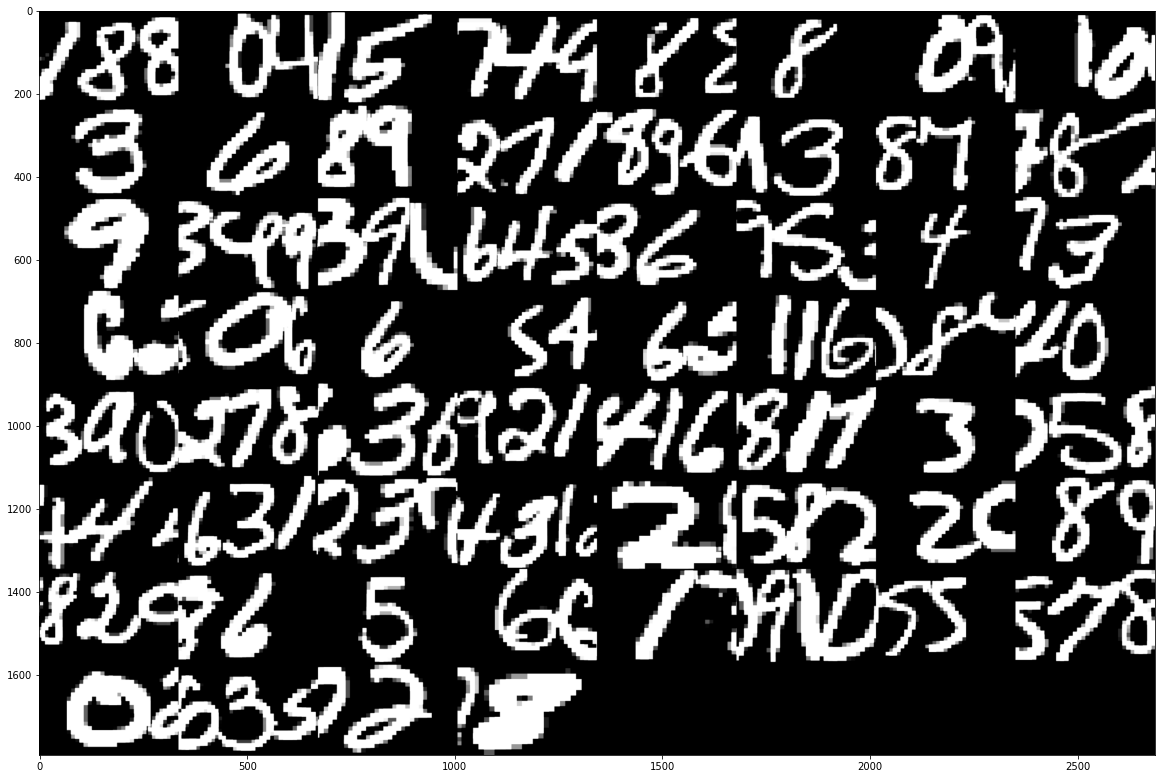

8 0 5 4 8 8 0 1 3 6 9 7 9 3 7 8 9 9 9 4 6 5 4 3 6 0 6 5 6 1 8 0 9 7 3 2 1 1 3 5 4 3 3 3 2 8 2 8 2 6 5 6 1 1 5 7 0 3 2 8 

In [2]:
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np

dataiter       = iter(custom_train_loader)
images, labels = next(dataiter)

img   = utils.make_grid(images, padding=0).cpu()
npimg = img.numpy()
plt.figure(figsize=(20, 14))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()
CLASSES = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9'

}
for label in labels:
    index = label.item()
    print(index, end=' ')